In [1]:
%load_ext autoreload
%autoreload 2


Number of training examples:  60000
Number of test examples:  10000


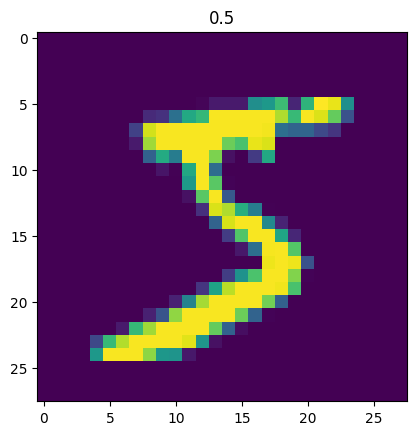

In [2]:
from src.datasets import MNISTDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


batch_size = 128
mnist_train = MNISTDataset(train=True)
mnist_test = MNISTDataset(train=False)

print("Number of training examples: ", len(mnist_train))
print("Number of test examples: ", len(mnist_test))

train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=True)

plt.imshow(mnist_train[0][0][0])
plt.title(str(mnist_train[0][1].item()))
plt.show()


In [59]:
from src.architecture.models import (
    FlattenLinear,
    FlattenLinearMDN,
    ConvolutionalMDN,
    BasicCNN,
)
import torch
from src.training import train_loop, mdn_loss, mse_loss, test_loop
from tqdm import tqdm


device = "cuda" if torch.cuda.is_available() else "cpu"

models = {}

model = FlattenLinear(
    input_dimension=(1, 28, 28),
    hidden_dims=[16, 64, 128, 64, 32],
    output_dimension=1,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
models["flatten_linear"] = {"model": model, "optimizer": optimizer, "loss": mse_loss}

model = FlattenLinearMDN(
    input_dimension=(1, 28, 28),
    hidden_dims=[16, 64, 128, 64, 32],
    output_dimension=1,
    n_mixtures=5,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
models["flatten_linear_mdn"] = {
    "model": model,
    "optimizer": optimizer,
    "loss": mdn_loss,
}

model = BasicCNN(
    input_dimension=(1, 28, 28),
    output_dimension=1,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
models["basic_cnn"] = {
    "model": model,
    "optimizer": optimizer,
    "loss": mse_loss,
}

model = ConvolutionalMDN(
    input_dimension=(1, 28, 28),
    output_dimension=1,
    n_mixtures=5,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
models["conv_mdn"] = {
    "model": model,
    "optimizer": optimizer,
    "loss": mdn_loss,
}


In [60]:
epochs = 5

for model_name, model_dict in models.items():
    print(model_name)
    train_losses = []
    test_losses = []

    for _ in tqdm(range(epochs)):
        train_loss = train_loop(
            model_dict["model"],
            train_loader,
            model_dict["optimizer"],
            model_dict["loss"],
            device,
        )

        test_loss = test_loop(
            model_dict["model"], test_loader, model_dict["loss"], device
        )
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    models[model_name]["train_losses"] = train_losses
    models[model_name]["test_losses"] = test_losses


flatten_linear


100%|██████████| 5/5 [00:43<00:00,  8.71s/it]


flatten_linear_mdn


100%|██████████| 5/5 [00:44<00:00,  8.94s/it]


basic_cnn


100%|██████████| 5/5 [00:43<00:00,  8.62s/it]


conv_mdn


100%|██████████| 5/5 [00:46<00:00,  9.26s/it]


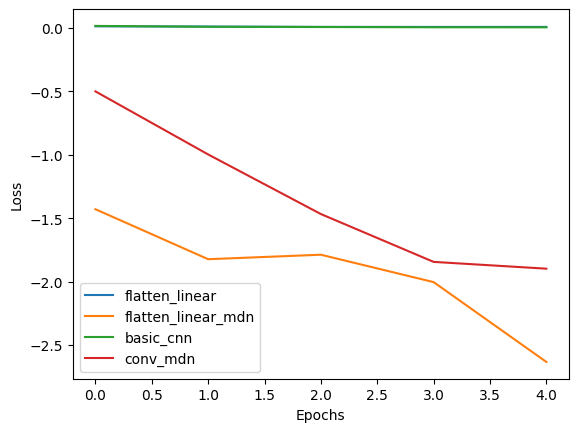

In [61]:
for model_name, model_dict in models.items():
    plt.plot(model_dict["test_losses"], label=model_name)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [105]:
# find a wrong prediction
count = 0
for i in range(len(mnist_test)):
    image, label = mnist_test[i]
    image = image.unsqueeze(0).to(device)
    prediction = models["flatten_linear"]["model"](image)

    if torch.abs(prediction.item() - label) > 0.5:
        print(i)
        count += 1

    if count == 40:
        break


259
445
565
582
740
965
1107
1191
1247
1260
1283
1326
1433
1500
1754
1790
1878
1987
2033
2053
2093
2185
2387
2406
2607
2648
2896
3251
3422
3503
3597
3751
3757
3774
3838
4065
4248
4289
4403
4699


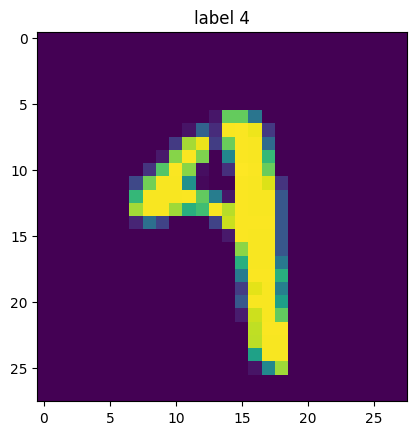

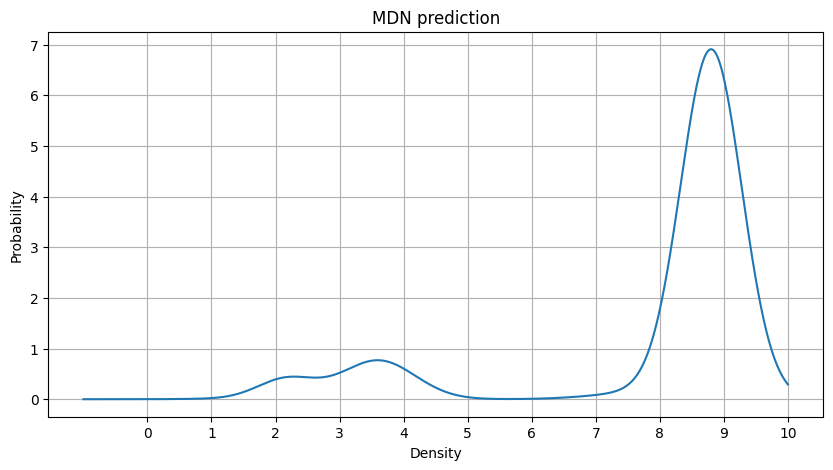

In [125]:
import numpy as np
from src.visualization import plot_mdn_prediction_1d

sample = 740  # 1987 # 8065  # 1033
image = mnist_test[sample][0]
label = mnist_test[sample][1]

model = models["conv_mdn"]["model"]


plot_mdn_prediction_1d(model, image, label, device, n_samples=1000)
